In [17]:
import numpy as np
import matplotlib.pyplot as plt
import zstandard
from scipy.interpolate import interp1d
import corsika

In [5]:
class ParticleInspector(corsika.CORSIKAReader):
    def __init__(self):
        super(ParticleInspector, self).__init__()
        self.p = []

    def particleHandler(self, part):
        self.p.append((self.eventNumber, part))

In [6]:
with open("data/DAT002110.zst", "rb") as f:
    r = ParticleInspector()
    z = zstandard.ZstdDecompressor()
    r.readTape(z.stream_reader(f))

In [7]:
len(r.p)

7161

In [8]:
for iev, p in r.p[200:225]:
    print ("EVENT " + str(iev) + " " + str(p))

EVENT 73 mu- 1.09 GeV/c -43079 -67364
EVENT 73 mu- 1.23 GeV/c -5579 -19073
EVENT 73 mu+ 1.12 GeV/c 81461 -103779
EVENT 73 mu- 0.76 GeV/c -7986 63601
EVENT 73 mu- 3.90 GeV/c -31296 -25692
EVENT 73 mu- 3.64 GeV/c -5721 48950
EVENT 73 mu+ 1.33 GeV/c 41472 105756
EVENT 73 mu+ 8.30 GeV/c -387 -1519
EVENT 73 mu- 17.23 GeV/c -1419 -5627
EVENT 73 mu- 15.12 GeV/c 3460 3997
EVENT 74 mu- 20.72 GeV/c -55711 14827
EVENT 74 mu+ 33.84 GeV/c 25943 1085
EVENT 74 mu+ 9.32 GeV/c -50425 -14207
EVENT 74 mu- 4.80 GeV/c 82931 62355
EVENT 74 mu+ 1.57 GeV/c 101848 -44660
EVENT 74 mu+ 23.99 GeV/c -95 5653
EVENT 75 mu+ 1.70 GeV/c 112900 -8672
EVENT 76 mu- 8.69 GeV/c -38329 25617
EVENT 76 mu+ 1.32 GeV/c -149208 -27786
EVENT 76 mu+ 3.99 GeV/c -54094 83723
EVENT 76 mu+ 1.67 GeV/c 108857 -46439
EVENT 76 mu- 1.96 GeV/c -128615 -65273
EVENT 77 mu- 1.32 GeV/c 144542 82930
EVENT 77 mu+ 0.55 GeV/c 29643 -57971
EVENT 77 mu- 5.23 GeV/c 16336 -34436


(-100.0, 100.0, -100.0, 100.0)

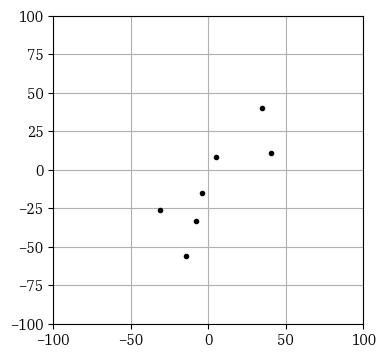

In [25]:
x, y = np.array([(p.x, p.y) for iev, p in r.p if iev == 73]).T
plt.figure(figsize=(4,4))
plt.plot(x/100, y/100, 'k.')
plt.axis((-100, 100, -100, 100))

## Atmospheres

### Real atmospheres

In [72]:
class MCIst(corsika.Atmosphere):
    """
    Atmosphere as predicted 3:00 am CST Nov 20 2023 over Kansas City (KMCI)
    """
    def __init__(self):
        super().__init__(SLP=29.94/29.92*101325)
        h_s = np.append(np.arange(19)*3000, (30000*3.28, 50000*3.28))
        T_s = np.array((  9, 3,   1,  -2,  -5, -10, -16, -23, -31, -38,
                        -47, -52, -51, -48, -49, -51, -53, -54, -56, -45, 
                        0)) + 273.16
        self.T_int = interp1d(h_s/3.28, T_s)

    def temperature(self, h):
        return self.T_int(h)
    
class MadisonSummer(corsika.Atmosphere):
    """ 
    Atmosphere over MSN 07/07/2020
    """
    def __init__(self, h=None):
        super().__init__(h, SLP=29.99/29.92*101325)
        h_s = np.hstack((np.arange(0, 57000, 3000), np.array((80000, 150000, 200000.))))
        T_s = np.array(( 26,  22,  16,   9,   3, 
                         -2,  -7, -13, -19, -26, 
                         -32, -40, -46, -51, -56, 
                         -61, -63, -65, -65, -65, -25, -10), 'd') + 273.16
        self.T_int = interp1d(h_s/3.28, T_s)
    
    def temperature(self, h):
        return self.T_int(h)

In [47]:
mci = MCIst()
isa = corsika.ISA()

Text(0.5, 0, 'Density rel to ISA')

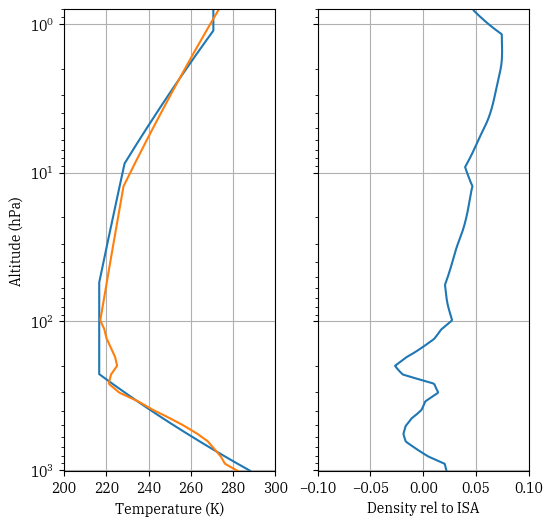

In [66]:
fix, (axT, axD) = plt.subplots(1, 2, figsize=(6,6), sharey=True)
axT.semilogy(isa.temperature(isa.h), isa.pressure / 100)
axT.semilogy(mci.temperature(mci.h), mci.pressure / 100)
axT.axis((200, 300, 1020, 0.8))
axT.set_xlabel('Temperature (K)')
axT.set_ylabel('Altitude (hPa)')

relD = (mci.density - isa.density) / isa.density
axD.semilogy(relD, mci.pressure / 100)
axD.axis((-0.1, 0.1, 1020, 0.8))
axD.set_xlabel('Density rel to ISA')

## CORSIKA Parametrization of ISA

In [69]:
corISA = corsika.CORSIKAAtmosphere.fitToAtmosphere(corsika.ISA(h=np.array((0, 11000, 20000, 32000, 50000), 'd')))
print (corISA.ATMA)
print (corISA.ATMB)
print (corISA.ATMC)
print (corISA.ATMLAY)

ATMA    -196.832 0.0176609 1.04279 0.292147
ATMB    1230.06 1308.9 1409.14 1417.15
ATMC    1.04155e+06 634132 616100 626470
ATMLAY  1.1000e+06 2.0000e+06 3.2000e+06 5.0000e+06


In [70]:
corISA.improveFit(corsika.ISA(h=np.arange(0, 50000, 500)))
print (corISA.ATMA)
print (corISA.ATMB)
print (corISA.ATMC)
print (corISA.ATMLAY)

ATMA    -126.412 0.290069 0.697782 0.218581
ATMB    1161.2 1313.6 1319.96 1024.73
ATMC    927719 632539 629863 669692
ATMLAY  1.1000e+06 2.0000e+06 3.2000e+06 5.0000e+06
